# Forecast output exploration

This notebook generates visual analyses of the generated forecast for a specified model. Note that the charts and commentary below were initially created for the gbm model.

In [1]:
model_name = "gbm"

Set date range for forecast inspection

In [2]:
min_date = '2016-07-01'
max_date = '2016-07-07'

In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In [16]:
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
with open(aml_dir + model_name + '_predictions.pkl', 'rb') as f:
    predictions = pickle.load(f)

In [17]:
predictions['error'] = predictions['predictions'] - predictions['demand']
predictions['abs_error'] = abs(predictions['error'])
predictions['abs_pct_error'] = abs(predictions['error']) / predictions['demand']

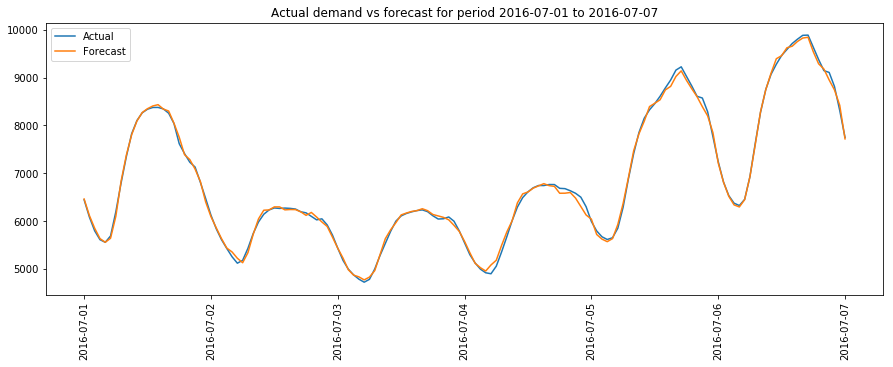

In [18]:
plot_df = predictions.loc[(predictions['timeStamp']>='2016-07-01') & (predictions['timeStamp']<='2016-07-07'), ]
plt.figure(figsize=(15, 5))
plt.plot(plot_df['timeStamp'], plot_df['demand'], markersize=1, label='Actual')
plt.plot(plot_df['timeStamp'], plot_df['predictions'], markersize=1, label='Forecast')
plt.xticks(rotation=90)
plt.title('Actual demand vs forecast for period ' + min_date + ' to ' + max_date)
plt.legend()
plt.show()

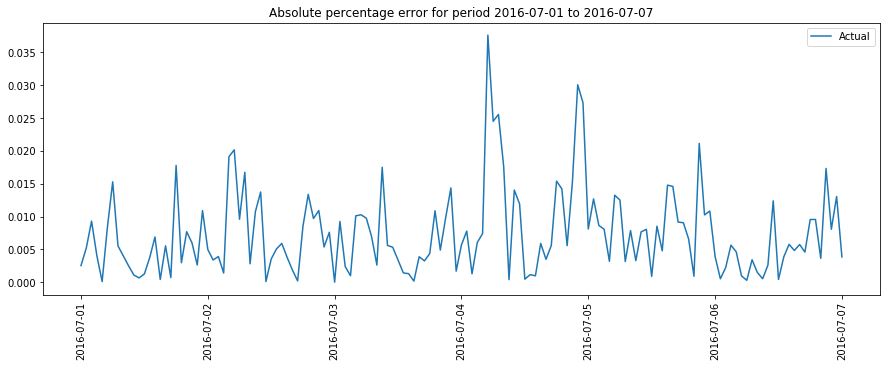

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(plot_df['timeStamp'], plot_df['abs_pct_error'], markersize=1, label='Actual')
plt.xticks(rotation=90)
plt.title('Absolute percentage error for period ' + min_date + ' to ' + max_date)
plt.legend()
plt.show()

Inspect forecast errors over entire test dataset. This should reveal the any heteroskedasticity - whether forecast error increases as time progresses. This could indicate that the model needs to be retrained more frequently so that the model can learn from more recent patterns in energy demand.

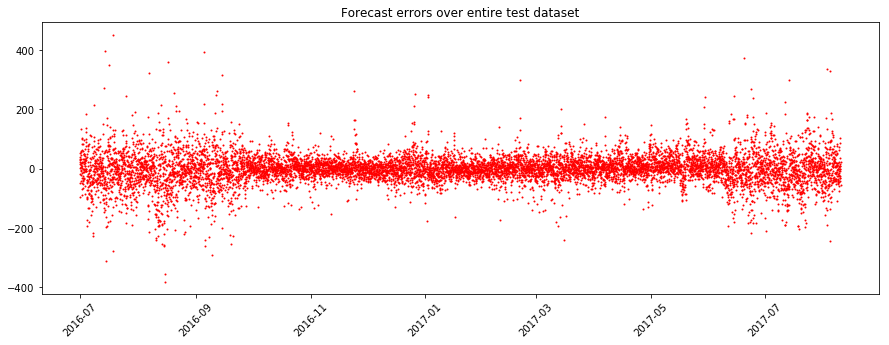

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(predictions['timeStamp'], predictions['error'], 'ro', markersize=1)
plt.title('Forecast errors over entire test dataset')
plt.xticks(rotation=45)
plt.show()

The chart above shows the errors are homoskedastic and the model seems to perform just as well at the beginning of the time period as at the end.

Now we can check if there are particular periods of time on which the model performs poorly:

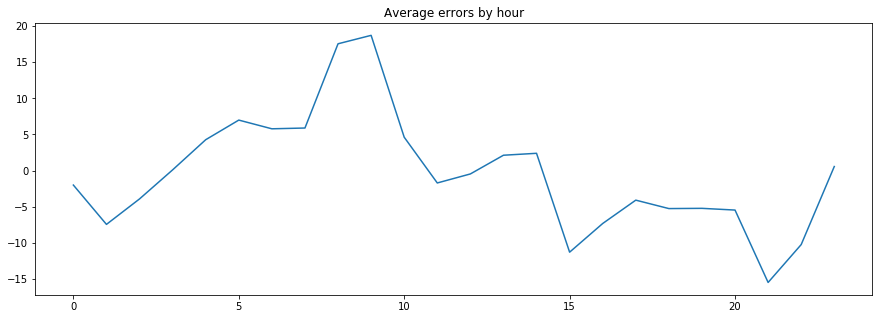

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(predictions[['hour', 'error']].groupby('hour').mean())
plt.title('Average errors by hour')
plt.show()

This chart shows the model struggles to forecast the the hours starting at 9am, 10am, 3pm and 10pm.

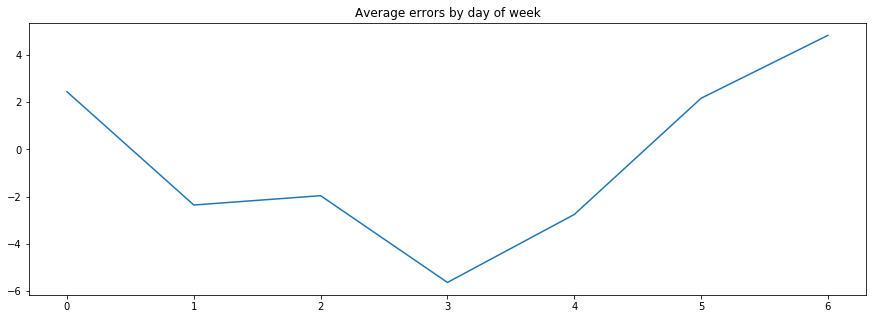

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(predictions[['dayofweek', 'error']].groupby('dayofweek').mean())
plt.title('Average errors by day of week')
plt.show()

The model performs poorly on Thursdays (3) and at the weekend (5 and 6).

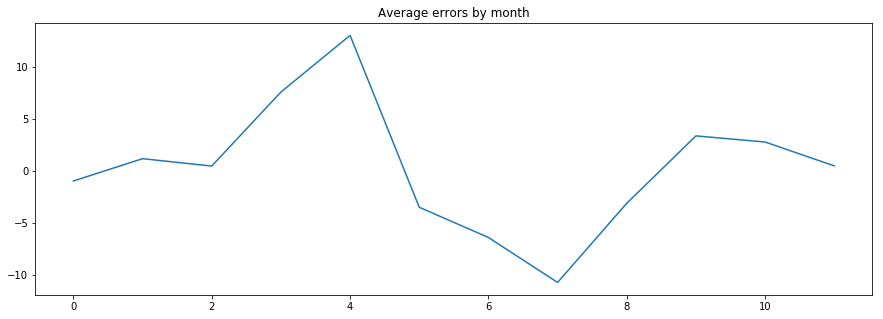

In [27]:
plt.figure(figsize=(15, 5))
plt.plot(predictions[['month', 'error']].groupby('month').mean())
plt.title('Average errors by month')
plt.show()

The model does not predict the months of May and August well.